In [3]:
import pandas as pd

from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import CompositionToOxidComposition
from matminer.featurizers.composition import OxidationStates
from matminer.featurizers.structure import DensityFeatures
from matminer.featurizers.structure.bonding import StructuralHeterogeneity
from matminer.featurizers.composition.orbital import ValenceOrbital
from matminer.featurizers.composition.element import Stoichiometry
from matminer.featurizers.composition.ion import IonProperty

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from figrecipes import PlotlyFig
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
from flatten_dict import flatten

In [4]:
from mp_api.client import MPRester
from emmet.core.summary import HasProps

with MPRester("4aBu5iIVl9Dt8fm9LGXMKkblVrhBpk10") as mpr:
    fields=["material_id", "formula_pretty", "structure", "formation_energy_per_atom", "e_total", "e_electronic", "band_gap"]
    docs = mpr.materials.summary.search(has_props = [HasProps.dielectric], fields=fields)
df = pd.DataFrame(docs)
df.head()

Retrieving SummaryDoc documents:   0%|          | 0/7277 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,"(builder_meta, None)","(nsites, None)","(elements, None)","(nelements, None)","(composition, None)","(composition_reduced, None)","(formula_pretty, Ba(PdS2)2)","(formula_anonymous, None)","(chemsys, None)","(volume, None)",...,"(weighted_surface_energy, None)","(weighted_work_function, None)","(surface_anisotropy, None)","(shape_factor, None)","(has_reconstructed, None)","(possible_species, None)","(has_props, None)","(theoretical, None)","(database_IDs, None)","(fields_not_requested, [builder_meta, nsites, ..."
1,"(builder_meta, None)","(nsites, None)","(elements, None)","(nelements, None)","(composition, None)","(composition_reduced, None)","(formula_pretty, NbO2F)","(formula_anonymous, None)","(chemsys, None)","(volume, None)",...,"(weighted_surface_energy, None)","(weighted_work_function, None)","(surface_anisotropy, None)","(shape_factor, None)","(has_reconstructed, None)","(possible_species, None)","(has_props, None)","(theoretical, None)","(database_IDs, None)","(fields_not_requested, [builder_meta, nsites, ..."
2,"(builder_meta, None)","(nsites, None)","(elements, None)","(nelements, None)","(composition, None)","(composition_reduced, None)","(formula_pretty, Sr(AsS2)2)","(formula_anonymous, None)","(chemsys, None)","(volume, None)",...,"(weighted_surface_energy, None)","(weighted_work_function, None)","(surface_anisotropy, None)","(shape_factor, None)","(has_reconstructed, None)","(possible_species, None)","(has_props, None)","(theoretical, None)","(database_IDs, None)","(fields_not_requested, [builder_meta, nsites, ..."
3,"(builder_meta, None)","(nsites, None)","(elements, None)","(nelements, None)","(composition, None)","(composition_reduced, None)","(formula_pretty, NaFe(SO4)2)","(formula_anonymous, None)","(chemsys, None)","(volume, None)",...,"(weighted_surface_energy, None)","(weighted_work_function, None)","(surface_anisotropy, None)","(shape_factor, None)","(has_reconstructed, None)","(possible_species, None)","(has_props, None)","(theoretical, None)","(database_IDs, None)","(fields_not_requested, [builder_meta, nsites, ..."
4,"(builder_meta, None)","(nsites, None)","(elements, None)","(nelements, None)","(composition, None)","(composition_reduced, None)","(formula_pretty, BH4NF4)","(formula_anonymous, None)","(chemsys, None)","(volume, None)",...,"(weighted_surface_energy, None)","(weighted_work_function, None)","(surface_anisotropy, None)","(shape_factor, None)","(has_reconstructed, None)","(possible_species, None)","(has_props, None)","(theoretical, None)","(database_IDs, None)","(fields_not_requested, [builder_meta, nsites, ..."


In [4]:
df1 = df1.drop(['builder_meta.emmet_version', 'builder_meta.pymatgen_version','builder_meta.pull_request', 'builder_meta.database_version','builder_meta.build_date', 'builder_meta.license','has_props.materials',
                'has_props.thermo','has_props.xas', 'has_props.grain_boundaries', 'has_props.chemenv','has_props.electronic_structure', 'has_props.absorption','has_props.bandstructure', 'has_props.dos', 'has_props.magnetism',
                'has_props.elasticity', 'has_props.dielectric','has_props.piezoelectric', 'has_props.surface_properties','has_props.oxi_states', 'has_props.provenance','has_props.charge_density', 'has_props.eos', 'has_props.phonon',
                'has_props.insertion_electrodes', 'has_props.substrates','deprecated','last_updated', 'origins', 'warnings', ], axis=1)

In [6]:
df1['structure'] = [doc.structure for doc in docs1]

In [7]:
df1 = df1.loc[:,['material_id', 'formula_pretty', 'nsites', 'elements', 'structure', 
       'energy_above_hull','band_gap','e_electronic', 'volume', 'density',
       'symmetry.crystal_system', 'symmetry.symbol', 'symmetry.number',
       'energy_per_atom', 'formation_energy_per_atom', 'efermi',
       'is_stable', 'is_metal', 'theoretical']]
df1

,material_id,formula_pretty,nsites,elements,structure,energy_above_hull,band_gap,e_electronic,volume,density,symmetry.crystal_system,symmetry.symbol,symmetry.number,energy_per_atom,formation_energy_per_atom,efermi,is_stable,is_metal,theoretical
0,mp-766094,NbO2F,16,"[F, Nb, O]","[[0.78519482 3.4528411 1.16915531] Nb, [1.807...",0.066868,2.8980,4.102533,253.915299,3.764366,Orthorhombic,P2_12_12_1,19,-8.578502,-3.099174,-1.312246,False,False,True
1,mp-28967,Ba(PdS2)2,14,"[Ba, Pd, S]","[[4.55529863 5.11963834 2.01471426] Ba, [1.801...",0.000000,0.7792,9.929365,316.341404,5.022717,Monoclinic,P2_1/m,11,-5.242962,-1.124079,3.160544,True,False,False
2,mp-36577,Sr(AsS2)2,7,"[As, S, Sr]","[[3.71023182 2.73341752 1.54388269] Sr, [1.302...",0.037997,1.7212,6.045051,196.220495,3.094976,Triclinic,P1,1,-11.723346,-0.766100,1.973632,False,False,True
3,mp-1102092,NaFe(SO4)2,48,"[Fe, Na, O, S]","[[ 0.11316166 -5.229512 -3.62081754] Na, [ 4...",0.000000,2.0944,3.096120,620.336826,2.901260,Monoclinic,C2/m,12,-6.757145,-1.948264,0.894954,True,False,False
4,mp-720391,BH4NF4,40,"[B, F, H, N]","[[1.44527675 5.85139728 5.13011033] B, [1.4452...",0.000000,7.4812,1.866232,374.200384,1.860992,Orthorhombic,Pnma,62,-5.595191,-1.970766,-3.531653,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7272,mp-7500,Na4SiO4,18,"[Na, O, Si]","[[5.62448509 1.17945917 2.43467983] Na, [3.822...",0.000000,3.2221,2.526415,225.915712,2.705515,Triclinic,P-1,2,-7.517430,-2.309309,1.173714,True,False,False
7273,mp-555354,KMn(SeO4)2,24,"[K, Mn, O, Se]",[[-1.141650e-02 2.962500e-03 4.074842e+00] K...,0.000000,0.0371,3.393856,378.346049,3.335171,Triclinic,P-1,2,-6.251920,-1.509977,0.162998,True,False,False
7274,mp-1019379,AlB3N4,8,"[Al, B, N]","[[0. 0. 0.] Al, [1.920524 1.920524 0. ] B...",0.360776,3.5993,4.702327,56.669477,3.382683,Cubic,P-43m,215,-9.279646,-1.118876,7.307842,False,False,True
7275,mp-568436,Sr7GeN6,56,"[Ge, N, Sr]","[[4.2748661 8.45638183 5.21793838] Sr, [ 4.87...",0.000000,1.1313,6.750888,1078.596828,4.741896,Orthorhombic,Pbcn,60,-5.488653,-0.738675,2.796015,True,False,False


In [8]:
df1 = df1.loc[(df1['e_electronic']> 2) & (df1['e_electronic'] < 70) & (df1['is_metal'] == False)]

In [9]:
len(df1)

6830

In [14]:
df1 = StrToComposition().featurize_dataframe(df1, "formula_pretty")
df1.head()

StrToComposition:   0%|          | 0/6830 [00:00<?, ?it/s]

,material_id,formula_pretty,nsites,elements,structure,energy_above_hull,band_gap,e_electronic,volume,density,symmetry.crystal_system,symmetry.symbol,symmetry.number,energy_per_atom,formation_energy_per_atom,efermi,is_stable,is_metal,theoretical,composition
0,mp-766094,NbO2F,16,"[F, Nb, O]","[[0.78519482 3.4528411 1.16915531] Nb, [1.807...",0.066868,2.8980,4.102533,253.915299,3.764366,Orthorhombic,P2_12_12_1,19,-8.578502,-3.099174,-1.312246,False,False,True,"(Nb, O, F)"
1,mp-28967,Ba(PdS2)2,14,"[Ba, Pd, S]","[[4.55529863 5.11963834 2.01471426] Ba, [1.801...",0.000000,0.7792,9.929365,316.341404,5.022717,Monoclinic,P2_1/m,11,-5.242962,-1.124079,3.160544,True,False,False,"(Ba, Pd, S)"
2,mp-36577,Sr(AsS2)2,7,"[As, S, Sr]","[[3.71023182 2.73341752 1.54388269] Sr, [1.302...",0.037997,1.7212,6.045051,196.220495,3.094976,Triclinic,P1,1,-11.723346,-0.766100,1.973632,False,False,True,"(Sr, As, S)"
3,mp-1102092,NaFe(SO4)2,48,"[Fe, Na, O, S]","[[ 0.11316166 -5.229512 -3.62081754] Na, [ 4...",0.000000,2.0944,3.096120,620.336826,2.901260,Monoclinic,C2/m,12,-6.757145,-1.948264,0.894954,True,False,False,"(Na, Fe, S, O)"
5,mp-4016,TlGaS2,32,"[Ga, S, Tl]","[[ 0.63562561 4.5465259 13.27575322] Tl, [0....",0.000000,1.7885,6.755384,806.670868,5.570099,Monoclinic,C2/c,15,-4.303304,-0.884233,2.752776,True,False,False,"(Tl, Ga, S)"


In [15]:
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df1 = ep_feat.featurize_dataframe(df1, col_id="composition")

ElementProperty:   0%|          | 0/6830 [00:00<?, ?it/s]

In [19]:
vo_feat = ValenceOrbital()
df1 = vo_feat.featurize_dataframe(df1, "composition")
df1.head()

ValenceOrbital:   0%|          | 0/6830 [00:00<?, ?it/s]

,material_id,formula_pretty,nsites,elements,structure,energy_above_hull,band_gap,e_electronic,volume,density,...,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons
0,mp-766094,NbO2F,16,"[F, Nb, O]","[[0.78519482 3.4528411 1.16915531] Nb, [1.807...",0.066868,2.8980,4.102533,253.915299,3.764366,...,81.000000,12.0,1.750000,3.250000,1.000000,0.0,0.291667,0.541667,0.166667,0.000000
1,mp-28967,Ba(PdS2)2,14,"[Ba, Pd, S]","[[4.55529863 5.11963834 2.01471426] Ba, [1.801...",0.000000,0.7792,9.929365,316.341404,5.022717,...,76.571429,70.0,1.428571,2.285714,2.857143,0.0,0.217391,0.347826,0.434783,0.000000
2,mp-36577,Sr(AsS2)2,7,"[As, S, Sr]","[[3.71023182 2.73341752 1.54388269] Sr, [1.302...",0.037997,1.7212,6.045051,196.220495,3.094976,...,56.653061,70.0,2.000000,3.142857,2.857143,0.0,0.250000,0.392857,0.357143,0.000000
3,mp-1102092,NaFe(SO4)2,48,"[Fe, Na, O, S]","[[ 0.11316166 -5.229512 -3.62081754] Na, [ 4...",0.000000,2.0944,3.096120,620.336826,2.901260,...,61.111111,12.0,1.916667,3.333333,0.500000,0.0,0.333333,0.579710,0.086957,0.000000
5,mp-4016,TlGaS2,32,"[Ga, S, Tl]","[[ 0.63562561 4.5465259 13.27575322] Tl, [0....",0.000000,1.7885,6.755384,806.670868,5.570099,...,47.250000,70.0,2.000000,2.500000,5.000000,3.5,0.153846,0.192308,0.384615,0.269231


In [20]:
unwanted_columns1 = ["avg s valence electrons","avg p valence electrons","avg d valence electrons","avg f valence electrons"]
df1 = df1.drop(unwanted_columns1, axis=1)

In [27]:
df2 = df1.loc[df1['theoretical'] == False]
df2

,material_id,formula_pretty,nsites,elements,structure,energy_above_hull,band_gap,e_electronic,volume,density,...,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons
1,mp-28967,Ba(PdS2)2,14,"[Ba, Pd, S]","[[4.55529863 5.11963834 2.01471426] Ba, [1.801...",0.0,0.7792,9.929365,316.341404,5.022717,...,70.0,229.0,159.0,137.000000,76.571429,70.0,0.217391,0.347826,0.434783,0.000000
3,mp-1102092,NaFe(SO4)2,48,"[Fe, Na, O, S]","[[ 0.11316166 -5.229512 -3.62081754] Na, [ 4...",0.0,2.0944,3.096120,620.336826,2.901260,...,12.0,229.0,217.0,57.833333,61.111111,12.0,0.333333,0.579710,0.086957,0.000000
5,mp-4016,TlGaS2,32,"[Ga, S, Tl]","[[ 0.63562561 4.5465259 13.27575322] Tl, [0....",0.0,1.7885,6.755384,806.670868,5.570099,...,64.0,194.0,130.0,99.500000,47.250000,70.0,0.153846,0.192308,0.384615,0.269231
6,mp-22192,Si3Ru2,40,"[Ru, Si]","[[3.34588423 0.9290511 7.01009019] Si, [0.574...",0.0,0.5511,20.441653,550.267973,6.914051,...,194.0,227.0,33.0,213.800000,15.840000,227.0,0.285714,0.214286,0.500000,0.000000
8,mp-3922,AgSbS2,16,"[Ag, S, Sb]","[[2.31044896 0. 0. ] Ag, [2.729...",0.0,1.3716,9.214055,387.339567,5.037409,...,70.0,225.0,155.0,132.750000,62.750000,70.0,0.184211,0.289474,0.526316,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7266,mp-555903,Al(IO3)3,26,"[Al, I, O]","[[4.49815825 2.59720217 0.42548915] Al, [ 4.49...",0.0,3.3466,4.035757,363.752262,5.036956,...,12.0,225.0,213.0,40.384615,39.301775,12.0,0.240741,0.481481,0.277778,0.000000
7271,mp-9687,K2PAu,8,"[Au, K, P]","[[5.44298085 1.87953259 4.64845531] K, [-0.981...",0.0,0.9515,6.641222,224.439187,4.529978,...,2.0,229.0,227.0,171.250000,84.625000,229.0,0.156250,0.093750,0.312500,0.437500
7272,mp-7500,Na4SiO4,18,"[Na, O, Si]","[[5.62448509 1.17945917 2.43467983] Na, [3.822...",0.0,3.2221,2.526415,225.915712,2.705515,...,12.0,229.0,217.0,132.333333,106.962963,12.0,0.437500,0.562500,0.000000,0.000000
7273,mp-555354,KMn(SeO4)2,24,"[K, Mn, O, Se]",[[-1.141650e-02 2.962500e-03 4.074842e+00] K...,0.0,0.0371,3.393856,378.346049,3.335171,...,12.0,229.0,217.0,47.500000,58.500000,12.0,0.261364,0.454545,0.284091,0.000000


In [28]:
sa_feat = Stoichiometry()
df2 = sa_feat.featurize_dataframe(df2, "composition", ignore_errors=True)
df2.head()

Stoichiometry:   0%|          | 0/4395 [00:00<?, ?it/s]

,material_id,formula_pretty,nsites,elements,structure,energy_above_hull,band_gap,e_electronic,volume,density,...,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm
1,mp-28967,Ba(PdS2)2,14,"[Ba, Pd, S]","[[4.55529863 5.11963834 2.01471426] Ba, [1.801...",0.0,0.7792,9.929365,316.341404,5.022717,...,0.217391,0.347826,0.434783,0.000000,3,0.654654,0.597048,0.575065,0.572069,0.571484
3,mp-1102092,NaFe(SO4)2,48,"[Fe, Na, O, S]","[[ 0.11316166 -5.229512 -3.62081754] Na, [ 4...",0.0,2.0944,3.096120,620.336826,2.901260,...,0.333333,0.579710,0.086957,0.000000,4,0.697217,0.670979,0.666805,0.666673,0.666667
5,mp-4016,TlGaS2,32,"[Ga, S, Tl]","[[ 0.63562561 4.5465259 13.27575322] Tl, [0....",0.0,1.7885,6.755384,806.670868,5.570099,...,0.153846,0.192308,0.384615,0.269231,3,0.612372,0.538609,0.506099,0.501109,0.500098
6,mp-22192,Si3Ru2,40,"[Ru, Si]","[[3.34588423 0.9290511 7.01009019] Si, [0.574...",0.0,0.5511,20.441653,550.267973,6.914051,...,0.285714,0.214286,0.500000,0.000000,2,0.721110,0.654213,0.615030,0.604895,0.601032
8,mp-3922,AgSbS2,16,"[Ag, S, Sb]","[[2.31044896 0. 0. ] Ag, [2.729...",0.0,1.3716,9.214055,387.339567,5.037409,...,0.184211,0.289474,0.526316,0.000000,3,0.612372,0.538609,0.506099,0.501109,0.500098


In [29]:
ip_feat = IonProperty()
df2 = ip_feat.featurize_dataframe(df2, "composition", ignore_errors=True)
df2.head()

IonProperty:   0%|          | 0/4395 [00:00<?, ?it/s]

,material_id,formula_pretty,nsites,elements,structure,energy_above_hull,band_gap,e_electronic,volume,density,...,frac f valence electrons,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,compound possible,max ionic char,avg ionic char
1,mp-28967,Ba(PdS2)2,14,"[Ba, Pd, S]","[[4.55529863 5.11963834 2.01471426] Ba, [1.801...",0.0,0.7792,9.929365,316.341404,5.022717,...,0.000000,3,0.654654,0.597048,0.575065,0.572069,0.571484,True,0.510331,0.061687
3,mp-1102092,NaFe(SO4)2,48,"[Fe, Na, O, S]","[[ 0.11316166 -5.229512 -3.62081754] Na, [ 4...",0.0,2.0944,3.096120,620.336826,2.901260,...,0.000000,4,0.697217,0.670979,0.666805,0.666673,0.666667,True,0.792998,0.099260
5,mp-4016,TlGaS2,32,"[Ga, S, Tl]","[[ 0.63562561 4.5465259 13.27575322] Tl, [0....",0.0,1.7885,6.755384,806.670868,5.570099,...,0.269231,3,0.612372,0.538609,0.506099,0.501109,0.500098,True,0.205784,0.043505
6,mp-22192,Si3Ru2,40,"[Ru, Si]","[[3.34588423 0.9290511 7.01009019] Si, [0.574...",0.0,0.5511,20.441653,550.267973,6.914051,...,0.000000,2,0.721110,0.654213,0.615030,0.604895,0.601032,False,0.022249,0.005340
8,mp-3922,AgSbS2,16,"[Ag, S, Sb]","[[2.31044896 0. 0. ] Ag, [2.729...",0.0,1.3716,9.214055,387.339567,5.037409,...,0.000000,3,0.612372,0.538609,0.506099,0.501109,0.500098,True,0.100238,0.021231


In [5]:
df2 = df2.drop('density',axis=1)

In [7]:
df_feat = DensityFeatures()
df2 = df_feat.featurize_dataframe(df2, "structure", ignore_errors=True)  # input the structure column to the featurizer
df2.head()

DensityFeatures:   0%|          | 0/4394 [00:00<?, ?it/s]

,material_id,formula_pretty,nsites,elements,structure,energy_above_hull,band_gap,e_electronic,log_e_electronic,volume,...,3-norm,5-norm,7-norm,10-norm,compound possible,max ionic char,avg ionic char,density,vpa,packing fraction
1,mp-28967,Ba(PdS2)2,14,"[Ba, Pd, S]","[[4.55529863 5.11963834 2.01471426] Ba, [1.801...",0.0,0.7792,9.929365,3.311701,316.341404,...,0.597048,0.575065,0.572069,0.571484,True,0.510331,0.061687,5.022717,22.595815,0.514463
3,mp-1102092,NaFe(SO4)2,48,"[Fe, Na, O, S]","[[ 0.11316166 -5.229512 -3.62081754] Na, [ 4...",0.0,2.0944,3.096120,1.630461,620.336826,...,0.670979,0.666805,0.666673,0.666667,True,0.792998,0.099260,2.901260,12.923684,0.332328
5,mp-4016,TlGaS2,32,"[Ga, S, Tl]","[[ 0.63562561 4.5465259 13.27575322] Tl, [0....",0.0,1.7885,6.755384,2.756038,806.670868,...,0.538609,0.506099,0.501109,0.500098,True,0.205784,0.043505,5.570099,25.208465,0.459283
6,mp-22192,Si3Ru2,40,"[Ru, Si]","[[3.34588423 0.9290511 7.01009019] Si, [0.574...",0.0,0.5511,20.441653,4.353440,550.267973,...,0.654213,0.615030,0.604895,0.601032,False,0.022249,0.005340,6.914051,13.756699,0.510753
8,mp-3922,AgSbS2,16,"[Ag, S, Sb]","[[2.31044896 0. 0. ] Ag, [2.729...",0.0,1.3716,9.214055,3.203836,387.339567,...,0.538609,0.506099,0.501109,0.500098,True,0.100238,0.021231,5.037409,24.208723,0.395569


In [17]:
df2 = df2.drop(['compound possible'], axis=1)

In [8]:
df2 = df2.dropna(axis=0)

In [9]:
sg_feat = StructuralHeterogeneity()
df2 = sg_feat.featurize_dataframe(df2, "structure", ignore_errors=True)  # input the structure column to the featurizer
df2.head()

StructuralHeterogeneity:   0%|          | 0/4389 [00:00<?, ?it/s]

,material_id,formula_pretty,nsites,elements,structure,energy_above_hull,band_gap,e_electronic,log_e_electronic,volume,...,packing fraction,mean absolute deviation in relative bond length,max relative bond length,min relative bond length,minimum neighbor distance variation,maximum neighbor distance variation,range neighbor distance variation,mean neighbor distance variation,avg_dev neighbor distance variation,mean absolute deviation in relative cell size
1,mp-28967,Ba(PdS2)2,14,"[Ba, Pd, S]","[[4.55529863 5.11963834 2.01471426] Ba, [1.801...",0.0,0.7792,9.929365,3.311701,316.341404,...,0.514463,0.077369,1.151566,0.910792,0.043201,0.224298,0.181097,0.169137,0.045062,0.162070
3,mp-1102092,NaFe(SO4)2,48,"[Fe, Na, O, S]","[[ 0.11316166 -5.229512 -3.62081754] Na, [ 4...",0.0,2.0944,3.096120,1.630461,620.336826,...,0.332328,0.146083,1.164790,0.634415,0.015799,0.218652,0.202853,0.148776,0.074639,0.243993
5,mp-4016,TlGaS2,32,"[Ga, S, Tl]","[[ 0.63562561 4.5465259 13.27575322] Tl, [0....",0.0,1.7885,6.755384,2.756038,806.670868,...,0.459283,0.098067,1.154098,0.828667,0.058578,0.212127,0.153549,0.150443,0.045354,0.180586
6,mp-22192,Si3Ru2,40,"[Ru, Si]","[[3.34588423 0.9290511 7.01009019] Si, [0.574...",0.0,0.5511,20.441653,4.353440,550.267973,...,0.510753,0.023149,1.035262,0.945164,0.065005,0.115715,0.050711,0.083396,0.013632,0.051852
8,mp-3922,AgSbS2,16,"[Ag, S, Sb]","[[2.31044896 0. 0. ] Ag, [2.729...",0.0,1.3716,9.214055,3.203836,387.339567,...,0.395569,0.019723,1.086900,0.960769,0.152569,0.195117,0.042548,0.176178,0.013690,0.033956


In [12]:
df2 = CompositionToOxidComposition().featurize_dataframe(df2, "composition",ignore_errors=True)

os_feat = OxidationStates()
df2 = os_feat.featurize_dataframe(df2, "composition_oxid", ignore_errors=True)
df2.head()

CompositionToOxidComposition:   0%|          | 0/4389 [00:00<?, ?it/s]

OxidationStates:   0%|          | 0/4389 [00:00<?, ?it/s]

,material_id,formula_pretty,nsites,elements,structure,energy_above_hull,band_gap,e_electronic,log_e_electronic,volume,...,maximum neighbor distance variation,range neighbor distance variation,mean neighbor distance variation,avg_dev neighbor distance variation,mean absolute deviation in relative cell size,composition_oxid,minimum oxidation state,maximum oxidation state,range oxidation state,std_dev oxidation state
1,mp-28967,Ba(PdS2)2,14,"[Ba, Pd, S]","[[4.55529863 5.11963834 2.01471426] Ba, [1.801...",0.0,0.7792,9.929365,3.311701,316.341404,...,0.224298,0.181097,0.169137,0.045062,0.162070,"(Ba2+, Pd2+, Pd4+, S2-)",-2.0,4.0,6.0,3.055050
3,mp-1102092,NaFe(SO4)2,48,"[Fe, Na, O, S]","[[ 0.11316166 -5.229512 -3.62081754] Na, [ 4...",0.0,2.0944,3.096120,1.630461,620.336826,...,0.218652,0.202853,0.148776,0.074639,0.243993,"(Na+, Fe3+, S6+, O2-)",-2.0,6.0,8.0,4.299591
5,mp-4016,TlGaS2,32,"[Ga, S, Tl]","[[ 0.63562561 4.5465259 13.27575322] Tl, [0....",0.0,1.7885,6.755384,2.756038,806.670868,...,0.212127,0.153549,0.150443,0.045354,0.180586,"(Tl+, Ga3+, S2-)",-2.0,3.0,5.0,2.683282
6,mp-22192,Si3Ru2,40,"[Ru, Si]","[[3.34588423 0.9290511 7.01009019] Si, [0.574...",0.0,0.5511,20.441653,4.353440,550.267973,...,0.115715,0.050711,0.083396,0.013632,0.051852,"(Si4-, Si4+, Ru2+)",-4.0,4.0,8.0,4.183300
8,mp-3922,AgSbS2,16,"[Ag, S, Sb]","[[2.31044896 0. 0. ] Ag, [2.729...",0.0,1.3716,9.214055,3.203836,387.339567,...,0.195117,0.042548,0.176178,0.013690,0.033956,"(Ag+, Sb3+, S2-)",-2.0,3.0,5.0,2.683282


In [15]:
df2['log_e_electronic'] = np.log2(df2['e_electronic'])

In [20]:
df2.columns.values

array(['material_id', 'formula_pretty', 'nsites', 'elements', 'structure',
       'energy_above_hull', 'band_gap', 'e_electronic',
       'log_e_electronic', 'volume', 'symmetry.crystal_system',
       'symmetry.symbol', 'symmetry.number', 'energy_per_atom',
       'formation_energy_per_atom', 'efermi', 'is_stable', 'is_metal',
       'theoretical', 'composition', 'MagpieData minimum Number',
       'MagpieData maximum Number', 'MagpieData range Number',
       'MagpieData mean Number', 'MagpieData avg_dev Number',
       'MagpieData mode Number', 'MagpieData minimum MendeleevNumber',
       'MagpieData maximum MendeleevNumber',
       'MagpieData range MendeleevNumber',
       'MagpieData mean MendeleevNumber',
       'MagpieData avg_dev MendeleevNumber',
       'MagpieData mode MendeleevNumber',
       'MagpieData minimum AtomicWeight',
       'MagpieData maximum AtomicWeight', 'MagpieData range AtomicWeight',
       'MagpieData mean AtomicWeight', 'MagpieData avg_dev AtomicWeight',


In [14]:
df2 = df2.dropna()

In [107]:
df2 = df2.loc[df2['energy_above_hull'] < 1]

In [16]:
len(df2)

4249

In [21]:
excluded = ['material_id', 'formula_pretty', 'nsites', 'elements', 'structure',
       'energy_above_hull', 'band_gap', 'e_electronic','log_e_electronic', 'volume',
       'symmetry.crystal_system', 'symmetry.symbol',
       'energy_per_atom', 'formation_energy_per_atom',
       'efermi', 'is_stable', 'is_metal', 'theoretical', 'composition', 'composition_oxid','compound_possible']
X = df2.drop(excluded, axis=1)

In [22]:
X.columns.values

array(['symmetry.number', 'MagpieData minimum Number',
       'MagpieData maximum Number', 'MagpieData range Number',
       'MagpieData mean Number', 'MagpieData avg_dev Number',
       'MagpieData mode Number', 'MagpieData minimum MendeleevNumber',
       'MagpieData maximum MendeleevNumber',
       'MagpieData range MendeleevNumber',
       'MagpieData mean MendeleevNumber',
       'MagpieData avg_dev MendeleevNumber',
       'MagpieData mode MendeleevNumber',
       'MagpieData minimum AtomicWeight',
       'MagpieData maximum AtomicWeight', 'MagpieData range AtomicWeight',
       'MagpieData mean AtomicWeight', 'MagpieData avg_dev AtomicWeight',
       'MagpieData mode AtomicWeight', 'MagpieData minimum MeltingT',
       'MagpieData maximum MeltingT', 'MagpieData range MeltingT',
       'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT',
       'MagpieData mode MeltingT', 'MagpieData minimum Column',
       'MagpieData maximum Column', 'MagpieData range Column',
       'Mag

In [42]:
len(X.columns)

162

In [38]:
df2 = df2.reset_index()

In [44]:
print(np.mean(df2["e_electronic"]), np.median(df2["e_electronic"]), min(df2["e_electronic"]), max(df2["e_electronic"]))

5.982131751893055 4.284385513333334 2.0018889000000004 59.57412923842019


In [45]:
print(np.mean(df2["band_gap"]), np.median(df2["band_gap"]), min(df2["band_gap"]), max(df2["band_gap"]))

2.3639056248529067 2.0196 0.0011999999999998678 8.7161


In [46]:
print(np.mean(df2["energy_above_hull"]), np.median(df2["energy_above_hull"]), min(df2["energy_above_hull"]), max(df2["energy_above_hull"]))

0.008394633032162964 0.0 0.0 0.8835374915972203


In [24]:
y1 = df2["e_electronic"]

In [25]:
y2 = df2['band_gap']

In [26]:
y3 = df2['energy_above_hull']

In [27]:
y1_1 = df2['log_e_electronic']

In [28]:
# e_electronic: LR
lr_e = LinearRegression()
lr_e.fit(X, y1)

# get fit statistics
print('training R2 = ' + str(round(lr_e.score(X, y1), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y1, y_pred=lr_e.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation0 = KFold(n_splits=10, shuffle=True, random_state=0)
scores0 = cross_val_score(lr_e, X, y1, scoring='neg_mean_squared_error', cv=crossvalidation0, n_jobs=1)
rmse_scores0 = [np.sqrt(abs(s)) for s in scores0]
r2_scores0 = cross_val_score(lr_e, X, y1, scoring='r2', cv=crossvalidation0, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores0)
print(r2_scores0)
print('Folds: %i, mean R2: %.3f' % (len(scores0), np.mean(np.abs(r2_scores0))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores0), np.mean(np.abs(rmse_scores0))))

training R2 = 0.726
training RMSE = 2.791
Cross-validation results:
[2.2343354415905785, 2.5022397200620174, 2.2770101455367207, 2.6314481353535903, 3.797298294421273, 3.363959711767786, 3.1806671874754846, 2.9773097717149404, 3.106293039167227, 2.825643241091682]
[0.76386092 0.7090803  0.7788268  0.7120866  0.62182791 0.63307346
 0.68489906 0.72201039 0.69332395 0.72734925]
Folds: 10, mean R2: 0.705
Folds: 10, mean RMSE: 2.890


In [24]:
def corr_r2(y_true, y_pred):
    return(r2_score(2**y_true, 2**y_pred))

def corr_mse(y_true, y_pred):
    return(mean_squared_error(2**y_true, 2**y_pred))

sqr2 = make_scorer(corr_r2, greater_is_better=True)
sqmse = make_scorer(corr_mse, greater_is_better=False)

In [25]:
#log_e_electronic: LR
lr_ee = LinearRegression()
lr_ee.fit(X, y1_1)

# get fit statistics
print('training R2 = ' + str(round(corr_r2(y_true=y1_1, y_pred=lr_ee.predict(X)), 3)))
print('training RMSE = %.3f' % np.sqrt(corr_mse(y_true=y1_1, y_pred=lr_ee.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation1 = KFold(n_splits=10, shuffle=True, random_state=0)
scores1 = cross_val_score(lr_ee, X, y1_1, scoring=sqmse, cv=crossvalidation1, n_jobs=1)
rmse_scores1 = [np.sqrt(abs(s)) for s in scores1]
r2_scores1 = cross_val_score(lr_ee, X, y1_1, scoring=sqr2, cv=crossvalidation1, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores1)
print(r2_scores1)
print('Folds: %i, mean R2: %.3f' % (len(scores1), np.mean(np.abs(r2_scores1))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores1), np.mean(np.abs(rmse_scores1))))

training R2 = 0.746
training RMSE = 2.689
Cross-validation results:
[2.214746352243769, 2.292093116118054, 1.9215389242615606, 2.3898151224575974, 3.649928792614259, 3.289236970762484, 3.1015136224013715, 2.9338349174347536, 2.948799428973254, 2.7481736578980756]
[0.76798337 0.75589323 0.84249261 0.76253431 0.65061132 0.6491933
 0.70038702 0.73006956 0.72363344 0.74209463]
Folds: 10, mean R2: 0.732
Folds: 10, mean RMSE: 2.749


In [30]:
#band_gap: LR
lr_bg = LinearRegression()
lr_bg.fit(X, y2)

# get fit statistics
print('training R2 = ' + str(round(lr_bg.score(X, y2), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y2, y_pred=lr_bg.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation2 = KFold(n_splits=10, shuffle=True, random_state=0)
scores2 = cross_val_score(lr_bg, X, y2, scoring='neg_mean_squared_error', cv=crossvalidation2, n_jobs=1)
rmse_scores2 = [np.sqrt(abs(s)) for s in scores2]
r2_scores2 = cross_val_score(lr_bg, X, y2, scoring='r2', cv=crossvalidation2, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores2)
print(r2_scores2)
print('Folds: %i, mean R2: %.3f' % (len(scores2), np.mean(np.abs(r2_scores2))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores2), np.mean(np.abs(rmse_scores2))))

training R2 = 0.697
training RMSE = 0.882
Cross-validation results:
[0.8370998830442103, 0.920131114696451, 0.9370691473434126, 0.9763110120228036, 0.8972328510612735, 0.8759544507237501, 0.9390566829199918, 0.9293025626931887, 0.9045878741175709, 0.9224298970358]
[0.67369933 0.67408155 0.67375627 0.60371982 0.69520642 0.68387424
 0.68551133 0.68901052 0.67781841 0.66997709]
Folds: 10, mean R2: 0.673
Folds: 10, mean RMSE: 0.914


In [31]:
#energy_above_hull: LR
lr_eh = LinearRegression()
lr_eh.fit(X, y3)

# get fit statistics
print('training R2 = ' + str(round(lr_eh.score(X, y3), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y3, y_pred=lr_eh.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation3 = KFold(n_splits=10, shuffle=True, random_state=0)
scores3 = cross_val_score(lr_eh, X, y3, scoring='neg_mean_squared_error', cv=crossvalidation3, n_jobs=1)
rmse_scores3 = [np.sqrt(abs(s)) for s in scores3]
r2_scores3 = cross_val_score(lr_eh, X, y3, scoring='r2', cv=crossvalidation3, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores3)
print(r2_scores3)
print('Folds: %i, mean R2: %.3f' % (len(scores3), np.mean(r2_scores3)))
print('Folds: %i, mean RMSE: %.3f' % (len(scores3), np.mean(np.abs(rmse_scores3))))

training R2 = 0.237
training RMSE = 0.034
Cross-validation results:
[0.023955400172012423, 0.023074338805473698, 0.05519502367091558, 0.02869589488207001, 0.03150832287666154, 0.027894417187688602, 0.04456938274759602, 0.03939901457745467, 0.03393375664143564, 0.03725962975858957]
[ 0.04008303 -0.26144043  0.16515805  0.2193899  -0.11596073 -0.0756418
  0.19579667  0.20925151  0.21611767  0.12470553]
Folds: 10, mean R2: 0.072
Folds: 10, mean RMSE: 0.035


In [32]:
# e_electronic: RF
rf_e = RandomForestRegressor(n_estimators=50, random_state=1)
rf_e.fit(X, y1)

# get fit statistics
print('training R2 = ' + str(round(rf_e.score(X, y1), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y1, y_pred=rf_e.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation0 = KFold(n_splits=10, shuffle=True, random_state=0)
scores0 = cross_val_score(rf_e, X, y1, scoring='neg_mean_squared_error', cv=crossvalidation0, n_jobs=1)
rmse_scores0 = [np.sqrt(abs(s)) for s in scores0]
r2_scores0 = cross_val_score(rf_e, X, y1, scoring='r2', cv=crossvalidation0, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores0)
print(r2_scores0)
print('Folds: %i, mean R2: %.3f' % (len(scores0), np.mean(np.abs(r2_scores0))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores0), np.mean(np.abs(rmse_scores0))))

training R2 = 0.974
training RMSE = 0.857
Cross-validation results:
[1.5114277578259423, 1.7311765337143297, 1.9213079443228673, 2.3571682836442296, 3.2263398984467306, 2.1321887504794126, 2.422009827023881, 2.435579265710302, 2.710551954869683, 1.7064044112477808]
[0.89194474 0.8607491  0.84253047 0.76897795 0.72700148 0.85258935
 0.81728886 0.81396912 0.76648731 0.90056576]
Folds: 10, mean R2: 0.824
Folds: 10, mean RMSE: 2.215


In [26]:
#log_e_electronic: RF
rf_ee = RandomForestRegressor(n_estimators=50, random_state=1)
rf_ee.fit(X, y1_1)

# get fit statistics
print('training R2 = ' + str(round(corr_r2(y_true=y1_1, y_pred=rf_ee.predict(X)), 3)))
print('training RMSE = %.3f' % np.sqrt(corr_mse(y_true=y1_1, y_pred=rf_ee.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation1 = KFold(n_splits=10, shuffle=True, random_state=0)
scores1 = cross_val_score(rf_ee, X, y1_1, scoring=sqmse, cv=crossvalidation1, n_jobs=1)
rmse_scores1 = [np.sqrt(abs(s)) for s in scores1]
r2_scores1 = cross_val_score(rf_ee, X, y1_1, scoring=sqr2, cv=crossvalidation1, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores1)
print(r2_scores1)
print('Folds: %i, mean R2: %.3f' % (len(scores1), np.mean(np.abs(r2_scores1))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores1), np.mean(np.abs(rmse_scores1))))

training R2 = 0.959
training RMSE = 1.086
Cross-validation results:
[1.3882164507259696, 1.808402573035651, 1.95956570956248, 2.2112668935662376, 3.32138131435134, 2.345530403072021, 2.533740490456463, 2.5236056855056286, 2.687432269826885, 1.7901875050324731]
[0.90884395 0.84804831 0.83619686 0.79669195 0.71068062 0.82161444
 0.80004259 0.8002791  0.77045382 0.89056176]
Folds: 10, mean R2: 0.818
Folds: 10, mean RMSE: 2.257


In [34]:
#band_gap: RF
rf_bg = RandomForestRegressor(n_estimators=50, random_state=1)
rf_bg.fit(X, y2)

# get fit statistics
print('training R2 = ' + str(round(rf_bg.score(X, y2), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y2, y_pred=rf_bg.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation2 = KFold(n_splits=10, shuffle=True, random_state=0)
scores2 = cross_val_score(rf_bg, X, y2, scoring='neg_mean_squared_error', cv=crossvalidation2, n_jobs=1)
rmse_scores2 = [np.sqrt(abs(s)) for s in scores2]
r2_scores2 = cross_val_score(rf_bg, X, y2, scoring='r2', cv=crossvalidation2, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores2)
print(r2_scores2)
print('Folds: %i, mean R2: %.3f' % (len(scores2), np.mean(np.abs(r2_scores2))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores2), np.mean(np.abs(rmse_scores2))))

training R2 = 0.977
training RMSE = 0.242
Cross-validation results:
[0.6106276230582202, 0.6351290921482007, 0.6685712236844813, 0.7108979918772429, 0.6360099730089107, 0.6258647564500102, 0.6171519206846046, 0.6397883109912711, 0.6085619412919492, 0.6620920089591094]
[0.82637339 0.84471356 0.83392883 0.78989299 0.84684777 0.83861698
 0.86416692 0.85259778 0.85418279 0.82997451]
Folds: 10, mean R2: 0.838
Folds: 10, mean RMSE: 0.641


In [10]:
#energy_above_hull: RF
rf_eh = RandomForestRegressor(n_estimators=50, random_state=1)
rf_eh.fit(X, y3)

# get fit statistics
print('training R2 = ' + str(round(rf_eh.score(X, y3), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y3, y_pred=rf_eh.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation3 = KFold(n_splits=10, shuffle=True, random_state=0)
scores3 = cross_val_score(rf_eh, X, y3, scoring='neg_mean_squared_error', cv=crossvalidation3, n_jobs=1)
rmse_scores3 = [np.sqrt(abs(s)) for s in scores3]
r2_scores3 = cross_val_score(rf_eh, X, y3, scoring='r2', cv=crossvalidation3, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores3)
print(r2_scores3)
print('Folds: %i, mean R2: %.3f' % (len(scores3), np.mean(r2_scores3)))
print('Folds: %i, mean RMSE: %.3f' % (len(scores3), np.mean(np.abs(rmse_scores3))))

training R2 = 0.886
training RMSE = 0.013
Cross-validation results:
[0.01985847762664678, 0.019975383384386567, 0.049460340102562866, 0.02443580122557719, 0.029863959263367164, 0.026639375128426377, 0.03776582119678129, 0.03844878550463984, 0.02771909151740503, 0.03454824665042092]
[ 0.34034218  0.0546373   0.32962376  0.43395914 -0.00252014  0.01897256
  0.42258176  0.24693424  0.47694787  0.24746078]
Folds: 10, mean R2: 0.257
Folds: 10, mean RMSE: 0.031


In [11]:
# e_electronic: SVR
svr_e = SVR()
svr_e.fit(X, y1)

# get fit statistics
print('training R2 = ' + str(round(svr_e.score(X, y1), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y1, y_pred=svr_e.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation0 = KFold(n_splits=10, shuffle=True, random_state=0)
scores0 = cross_val_score(svr_e, X, y1, scoring='neg_mean_squared_error', cv=crossvalidation0, n_jobs=1)
rmse_scores0 = [np.sqrt(abs(s)) for s in scores0]
r2_scores0 = cross_val_score(svr_e, X, y1, scoring='r2', cv=crossvalidation0, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores0)
print(r2_scores0)
print('Folds: %i, mean R2: %.3f' % (len(scores0), np.mean(np.abs(r2_scores0))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores0), np.mean(np.abs(rmse_scores0))))

training R2 = 0.461
training RMSE = 3.916
Cross-validation results:
[2.9923449000300844, 3.2629355193392193, 3.388379066831246, 3.5254297447812406, 4.673570780760169, 4.614611055175052, 4.30733384527037, 3.911876396740644, 4.190342209759791, 4.122915132598753]
[0.57646001 0.50531096 0.51023635 0.48323108 0.42715425 0.30952532
 0.42212979 0.52009999 0.44192316 0.41952859]
Folds: 10, mean R2: 0.462
Folds: 10, mean RMSE: 3.899


In [28]:
#log_e_electronic: SVR
svr_ee = SVR()
svr_ee.fit(X, y1_1)

# get fit statistics
print('training R2 = ' + str(round(corr_r2(y_true=y1_1, y_pred=svr_ee.predict(X)), 3)))
print('training RMSE = %.3f' % np.sqrt(corr_mse(y_true=y1_1, y_pred=svr_ee.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation1 = KFold(n_splits=10, shuffle=True, random_state=0)
scores1 = cross_val_score(svr_ee, X, y1_1, scoring=sqmse, cv=crossvalidation1, n_jobs=1)
rmse_scores1 = [np.sqrt(abs(s)) for s in scores1]
r2_scores1 = cross_val_score(svr_ee, X, y1_1, scoring=sqr2, cv=crossvalidation1, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores1)
print(r2_scores1)
print('Folds: %i, mean R2: %.3f' % (len(scores1), np.mean(np.abs(r2_scores1))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores1), np.mean(np.abs(rmse_scores1))))

training R2 = 0.513
training RMSE = 3.721
Cross-validation results:
[2.6493089554678453, 2.977652665910447, 3.3727295399510724, 3.2927926699861376, 4.4998085329871795, 4.483672062324038, 4.105040809058541, 3.8069508444387252, 4.041615958548492, 3.9149027807534433]
[0.66800133 0.5880321  0.51474994 0.54918223 0.46895892 0.34815365
 0.4751343  0.54549878 0.48083536 0.47662375]
Folds: 10, mean R2: 0.512
Folds: 10, mean RMSE: 3.714


In [13]:
#band_gap: SVR
svr_bg = SVR()
svr_bg.fit(X, y2)

# get fit statistics
print('training R2 = ' + str(round(svr_bg.score(X, y2), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y2, y_pred=svr_bg.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation2 = KFold(n_splits=10, shuffle=True, random_state=0)
scores2 = cross_val_score(svr_bg, X, y2, scoring='neg_mean_squared_error', cv=crossvalidation2, n_jobs=1)
rmse_scores2 = [np.sqrt(abs(s)) for s in scores2]
r2_scores2 = cross_val_score(svr_bg, X, y2, scoring='r2', cv=crossvalidation2, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores2)
print(r2_scores2)
print('Folds: %i, mean R2: %.3f' % (len(scores2), np.mean(np.abs(r2_scores2))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores2), np.mean(np.abs(rmse_scores2))))

training R2 = 0.438
training RMSE = 1.201
Cross-validation results:
[1.0701967962469543, 1.2523228767641994, 1.2884712775846021, 1.210183054634183, 1.2226068997414132, 1.1840070967165017, 1.249055756811573, 1.2635207420432617, 1.1772200011350078, 1.1956504712916989]
[0.46667653 0.39627086 0.3831943  0.39112504 0.4340616  0.42242891
 0.44360267 0.42509488 0.45434962 0.44552007]
Folds: 10, mean R2: 0.426
Folds: 10, mean RMSE: 1.211


In [15]:
#energy_above_hull: SVR
svr_eh = SVR()
svr_eh.fit(X, y3)

# get fit statistics
print('training R2 = ' + str(round(svr_eh.score(X, y3), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y3, y_pred=svr_eh.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation3 = KFold(n_splits=10, shuffle=True, random_state=0)
scores3 = cross_val_score(svr_eh, X, y3, scoring='neg_mean_squared_error', cv=crossvalidation3, n_jobs=1)
rmse_scores3 = [np.sqrt(abs(s)) for s in scores3]
r2_scores3 = cross_val_score(svr_eh, X, y3, scoring='r2', cv=crossvalidation3, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores3)
print(r2_scores3)
print('Folds: %i, mean R2: %.3f' % (len(scores3), np.mean((r2_scores3))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores3), np.mean(np.abs(rmse_scores3))))

training R2 = -4.698
training RMSE = 0.092
Cross-validation results:
[0.09077859973100794, 0.09062660352145144, 0.10121818388007797, 0.09095538751358015, 0.09100036726873284, 0.08943137801675612, 0.09704715365562587, 0.09430789707328407, 0.09124029113305424, 0.09188885489194856]
[-12.78458733 -18.45895996  -1.80751119  -6.84244488  -8.30860555
 -10.05637937  -2.81292476  -3.53068401  -4.66709272  -4.32356787]
Folds: 10, mean R2: -7.359
Folds: 10, mean RMSE: 0.093


In [34]:
# e_electronic: XGBoost
xgb_e = XGBRegressor(n_estimators=50)
xgb_e.fit(X, y1)

# get fit statistics
print('training R2 = ' + str(round(xgb_e.score(X, y1), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y1, y_pred=xgb_e.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation0 = KFold(n_splits=10, shuffle=True, random_state=0)
scores0 = cross_val_score(xgb_e, X, y1, scoring='neg_mean_squared_error', cv=crossvalidation0, n_jobs=1)
rmse_scores0 = [np.sqrt(abs(s)) for s in scores0]
r2_scores0 = cross_val_score(xgb_e, X, y1, scoring='r2', cv=crossvalidation0, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores0)
print(r2_scores0)
print('Folds: %i, mean R2: %.3f' % (len(scores0), np.mean(np.abs(r2_scores0))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores0), np.mean(np.abs(rmse_scores0))))

training R2 = 0.994
training RMSE = 0.407
Cross-validation results:
[1.535441341874053, 1.472671611776054, 1.9550062793987586, 2.4010508818551313, 3.177347630546718, 2.045828051067207, 2.658110930442121, 2.5448066897296227, 2.5182510684213035, 1.6176110992199992]
[0.8884839  0.89923096 0.83695823 0.76029617 0.73522955 0.86428876
 0.77993071 0.79690927 0.79844523 0.91064471]
Folds: 10, mean R2: 0.827
Folds: 10, mean RMSE: 2.193


In [29]:
#log_e_electronic: XGBoost
xgb_ee = XGBRegressor(n_estimators = 50)
xgb_ee.fit(X, y1_1)

# get fit statistics
print('training R2 = ' + str(round(corr_r2(y_true=y1_1, y_pred=xgb_ee.predict(X)), 3)))
print('training RMSE = %.3f' % np.sqrt(corr_mse(y_true=y1_1, y_pred=xgb_ee.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation1 = KFold(n_splits=10, shuffle=True, random_state=0)
scores1 = cross_val_score(xgb_ee, X, y1_1, scoring=sqmse, cv=crossvalidation1, n_jobs=1)
rmse_scores1 = [np.sqrt(abs(s)) for s in scores1]
r2_scores1 = cross_val_score(xgb_ee, X, y1_1, scoring=sqr2, cv=crossvalidation1, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores1)
print(r2_scores1)
print('Folds: %i, mean R2: %.3f' % (len(scores1), np.mean(np.abs(r2_scores1))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores1), np.mean(np.abs(rmse_scores1))))

training R2 = 0.987
training RMSE = 0.605
Cross-validation results:
[1.3366011969809901, 1.7516329617316457, 1.7626221807801419, 2.11533823874447, 3.234651916565844, 2.0325835135059878, 2.592509244936157, 2.340376467117904, 2.7183535391848515, 1.5762086897285361]
[0.91549648 0.85743874 0.86746792 0.81394905 0.72559302 0.86604024
 0.79065921 0.82822816 0.76514117 0.91516023]
Folds: 10, mean R2: 0.835
Folds: 10, mean RMSE: 2.146


In [18]:
#band_gap: XGBoost
xgb_bg = XGBRegressor(n_estimators = 50)
xgb_bg.fit(X, y2)

# get fit statistics
print('training R2 = ' + str(round(xgb_bg.score(X, y2), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y2, y_pred=xgb_bg.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation2 = KFold(n_splits=10, shuffle=True, random_state=0)
scores2 = cross_val_score(xgb_bg, X, y2, scoring='neg_mean_squared_error', cv=crossvalidation2, n_jobs=1)
rmse_scores2 = [np.sqrt(abs(s)) for s in scores2]
r2_scores2 = cross_val_score(xgb_bg, X, y2, scoring='r2', cv=crossvalidation2, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores2)
print(r2_scores2)
print('Folds: %i, mean R2: %.3f' % (len(scores2), np.mean(np.abs(r2_scores2))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores2), np.mean(np.abs(rmse_scores2))))

training R2 = 0.98
training RMSE = 0.228
Cross-validation results:
[0.5739741560559048, 0.6152349800627984, 0.6220518526411671, 0.6515562817231886, 0.613954340195855, 0.6395686212633818, 0.6106043138000181, 0.6299299754925374, 0.6106597825788643, 0.6698816381062629]
[0.84659197 0.85428927 0.85623536 0.82350604 0.85728566 0.83147236
 0.86703384 0.85710535 0.85317574 0.82595021]
Folds: 10, mean R2: 0.847
Folds: 10, mean RMSE: 0.624


In [31]:
#energy_above_hull: XGBoost
xgb_eh = XGBRegressor(n_estimators = 50)
xgb_eh.fit(X, y3)

# get fit statistics
print('training R2 = ' + str(round(xgb_eh.score(X, y3), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y3, y_pred=xgb_eh.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation4 = KFold(n_splits=10, shuffle=True, random_state=0)
scores3 = cross_val_score(xgb_eh, X, y3, scoring='neg_mean_squared_error', cv=crossvalidation4, n_jobs=1)
rmse_scores3 = [np.sqrt(abs(s)) for s in scores3]
r2_scores3 = cross_val_score(xgb_eh, X, y3, scoring='r2', cv=crossvalidation4, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores3)
print(r2_scores3)
print('Folds: %i, mean R2: %.3f' % (len(scores3), np.mean((r2_scores3))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores3), np.mean(np.abs(rmse_scores3))))

training R2 = 0.972
training RMSE = 0.006
Cross-validation results:
[0.020951100165243746, 0.023632429846908422, 0.04922757702362892, 0.024994703023551373, 0.040725107894671556, 0.023973165615371033, 0.03930806935993845, 0.04033094152645881, 0.02744404666456191, 0.03420962991837601]
[ 0.26575588 -0.32319841  0.33591857  0.40776976 -0.86433016  0.20551837
  0.3744586   0.17140106  0.48727642  0.26214017]
Folds: 10, mean R2: 0.132
Folds: 10, mean RMSE: 0.032


In [20]:
#e_electronic: MLP 100,10
mlp_e = MLPRegressor(hidden_layer_sizes=(100,10),random_state=0,max_iter=1000, activation='relu')
mlp_e.fit(X, y1)

# get fit statistics
print('training R2 = ' + str(round(mlp_e.score(X, y1), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y1, y_pred=mlp_e.predict(X))))


# Use 10-fold cross validation (90% training, 10% test)
crossvalidation0 = KFold(n_splits=10, shuffle=True, random_state=0)
scores0 = cross_val_score(mlp_e, X, y1, scoring='neg_mean_squared_error', cv=crossvalidation0, n_jobs=1)
rmse_scores0 = [np.sqrt(abs(s)) for s in scores0]
r2_scores0 = cross_val_score(mlp_e, X, y1, scoring='r2', cv=crossvalidation0, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores0)
print(r2_scores0)
print('Folds: %i, mean R2: %.3f' % (len(scores0), np.mean(np.abs(r2_scores0))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores0), np.mean(np.abs(rmse_scores0))))


training R2 = 0.853
training RMSE = 2.046
Cross-validation results:
[2.17627767863368, 2.535898463513545, 2.554375215273912, 2.8012556209088832, 3.6868979745003507, 3.2281677434983425, 3.2684199046384013, 3.3709668067504475, 3.3614505676123363, 3.4176361127530366]
[0.77597332 0.70120108 0.72166235 0.67372955 0.64349774 0.66209879
 0.66727232 0.64363958 0.64087265 0.60113706]
Folds: 10, mean R2: 0.673
Folds: 10, mean RMSE: 3.040


In [30]:
#log_e_electronic: MLP 100
mlp_ee = MLPRegressor(hidden_layer_sizes=(100,),random_state=0,max_iter=1000, activation='logistic')
mlp_ee.fit(X, y1_1)

# get fit statistics
print('training R2 = ' + str(round(corr_r2(y_true=y1_1, y_pred=mlp_ee.predict(X)), 3)))
print('training RMSE = %.3f' % np.sqrt(corr_mse(y_true=y1_1, y_pred=mlp_ee.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation1 = KFold(n_splits=10, shuffle=True, random_state=0)
scores1 = cross_val_score(mlp_ee, X, y1_1, scoring=sqmse, cv=crossvalidation1, n_jobs=1)
rmse_scores1 = [np.sqrt(abs(s)) for s in scores1]
r2_scores1 = cross_val_score(mlp_ee, X, y1_1, scoring=sqr2, cv=crossvalidation1, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores1)
print(r2_scores1)
print('Folds: %i, mean R2: %.3f' % (len(scores1), np.mean(np.abs(r2_scores1))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores1), np.mean(np.abs(rmse_scores1))))


training R2 = 0.698
training RMSE = 2.931
Cross-validation results:
[2.4582482319571652, 2.9018979759689505, 2.708206331798047, 2.915041859962439, 4.09623719566682, 4.098582091715891, 3.9450913925604354, 2.8353153589886353, 3.7021341392940577, 3.542608005175968]
[0.71416027 0.60872726 0.68712846 0.64668519 0.55994167 0.45531573
 0.51523933 0.74789396 0.56438852 0.57143348]
Folds: 10, mean R2: 0.607
Folds: 10, mean RMSE: 3.320


In [22]:
#band_gap: MLP 100
mlp_bg = MLPRegressor(hidden_layer_sizes=(100,),random_state=0,max_iter=1000, activation='logistic')
mlp_bg.fit(X, y2)

# get fit statistics
print('training R2 = ' + str(round(mlp_bg.score(X, y2), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y2, y_pred=mlp_bg.predict(X))))


# Use 10-fold cross validation (90% training, 10% test)
crossvalidation2 = KFold(n_splits=10, shuffle=True, random_state=0)
scores2 = cross_val_score(mlp_bg, X, y2, scoring='neg_mean_squared_error', cv=crossvalidation2, n_jobs=1)
rmse_scores2 = [np.sqrt(abs(s)) for s in scores2]
r2_scores2 = cross_val_score(mlp_bg, X, y2, scoring='r2', cv=crossvalidation2, n_jobs=1)

print('Cross-validation results:')
print(rmse_scores2)
print(r2_scores2)
print('Folds: %i, mean R2: %.3f' % (len(scores2), np.mean(np.abs(r2_scores2))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores2), np.mean(np.abs(rmse_scores2))))


training R2 = 0.717
training RMSE = 0.852
Cross-validation results:
[0.8832669515102081, 0.9900347990219589, 1.0336749493600936, 1.0135373037768778, 1.003967284852036, 1.0246785944357368, 1.0161942599867992, 0.9742501669763869, 0.9807229251089719, 0.9767769558955095]
[0.63671508 0.62267948 0.6030216  0.57292372 0.61837695 0.56741429
 0.63172278 0.65819973 0.62130301 0.62994339]
Folds: 10, mean R2: 0.616
Folds: 10, mean RMSE: 0.990


In [33]:
#energy_above_hull: MLP 162,20
mlp_eh = MLPRegressor(hidden_layer_sizes=(162,20),random_state=0,max_iter=1000, activation='logistic')
mlp_eh.fit(X, y3)

# get fit statistics
print('training R2 = ' + str(round(mlp_eh.score(X, y3), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y3, y_pred=mlp_eh.predict(X))))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation4 = KFold(n_splits=10, shuffle=True, random_state=0)
scores3 = cross_val_score(mlp_eh, X, y3, scoring='neg_mean_squared_error', cv=crossvalidation4, n_jobs=1)
rmse_scores3 = [np.sqrt(abs(s)) for s in scores3]
r2_scores3 = cross_val_score(mlp_eh, X, y3, scoring='r2', cv=crossvalidation4, n_jobs=1)

print('Cross-validation results:')
print(scores3)
print(r2_scores3)
print('Folds: %i, mean R2: %.3f' % (len(scores3), np.mean((r2_scores3))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores3), np.mean(np.abs(rmse_scores3))))


training R2 = 0.168
training RMSE = 0.035
Cross-validation results:
[-0.00059945 -0.00049997 -0.00349547 -0.00102083 -0.00087702 -0.00065674
 -0.00222101 -0.00184791 -0.00137194 -0.00153162]
[-0.00272558 -0.18455313  0.04212227  0.03228377  0.01415794  0.09212114
  0.10082632  0.05865547  0.0660501   0.03432833]
Folds: 10, mean R2: 0.025
Folds: 10, mean RMSE: 0.036


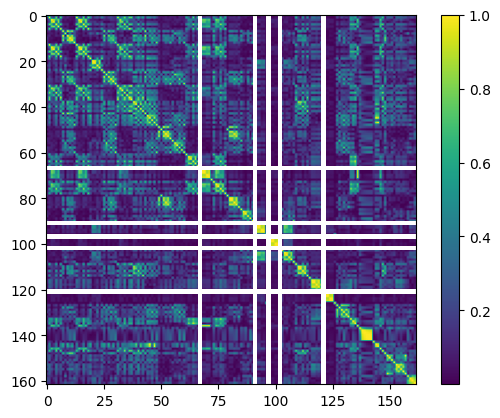

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline   
corr_matrix = X.corr().abs()   # we take the absolute value
fig, ax = plt.subplots()
h = ax.imshow(corr_matrix)
plt.colorbar(h)
plt.show()

In [56]:
from figrecipes import PlotlyFig
from sklearn.model_selection import cross_val_predict

pf_xgb_e = PlotlyFig(x_title='MP dielectric constant (electronic)',
                  y_title='Predicted dielectric constant (electronic)',
                  title='XBBoost regression of dielectric constant (electronic)',
                  mode="offline",
                  filename="xgb_e.html",)

pf_xgb_e.xy([(y1, cross_val_predict(xgb_e, X, y1, cv=crossvalidation0)), ([0, 60], [0, 60])], 
      labels=df2['formula_pretty'], modes=['markers', 'lines'],
      lines=[{}, {'color': 'black', 'dash': 'dash'}], showlegends=False)

C:\Users\vitom\AppData\Roaming\Python\Python311\site-packages\figrecipes\plot.py:599: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [57]:
pf_rf_bg = PlotlyFig(x_title='MP band gap energy (eV)',
                  y_title='Predicted band gap energy (eV)',
                  title='Random forest regression of band gap energy',
                  mode="offline",  
                  filename="rf_bg.html")

pf_rf_bg.xy([(y2, cross_val_predict(rf_bg, X, y2, cv=crossvalidation1)), ([0, 10], [0, 10])], 
      labels=df2['formula_pretty'], modes=['markers', 'lines'],
      lines=[{}, {'color': 'black', 'dash': 'dash'}], showlegends=False)

C:\Users\vitom\AppData\Roaming\Python\Python311\site-packages\figrecipes\plot.py:599: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [58]:
pf_xgb_bg = PlotlyFig(x_title='MP band gap energy (eV)',
                  y_title='Predicted band gap energy (eV)',
                  title='XBBoost regression of band gap energy',
                  mode="offline",  
                  filename="xgb_bg.html")

pf_xgb_bg.xy([(y2, cross_val_predict(xgb_bg, X, y2, cv=crossvalidation1)), ([0, 10], [0, 10])], 
      labels=df2['formula_pretty'], modes=['markers', 'lines'],
      lines=[{}, {'color': 'black', 'dash': 'dash'}], showlegends=False)

C:\Users\vitom\AppData\Roaming\Python\Python311\site-packages\figrecipes\plot.py:599: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [60]:
pf_rf_ehull = PlotlyFig(x_title='MP energy above hull (eV)',
                  y_title='Predicted energy above hull (eV)',
                  title='Random forest regression of energy above hull',
                  mode="offline",  
                  filename="rf_ehull.html")

pf_rf_ehull.xy([(y3, cross_val_predict(rf_eh, X, y3, cv=crossvalidation1)), ([0, 1], [0, 1])], 
      labels=df2['formula_pretty'], modes=['markers', 'lines'],
      lines=[{}, {'color': 'black', 'dash': 'dash'}], showlegends=False)

C:\Users\vitom\AppData\Roaming\Python\Python311\site-packages\figrecipes\plot.py:599: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [59]:
pf_xgb_ehull = PlotlyFig(x_title='MP energy above hull (eV)',
                  y_title='Predicted energy above hull (eV)',
                  title='XBBoost regression of energy above hull',
                  mode="offline",  
                  filename="xgb_ehull.html")

pf_xgb_bg.xy([(y3, cross_val_predict(xgb_eh, X, y3, cv=crossvalidation1)), ([0, 1], [0, 1])], 
      labels=df2['formula_pretty'], modes=['markers', 'lines'],
      lines=[{}, {'color': 'black', 'dash': 'dash'}], showlegends=False)

C:\Users\vitom\AppData\Roaming\Python\Python311\site-packages\figrecipes\plot.py:599: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [9]:
#energy_above_hull: XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

xgbc_eh = RandomForestClassifier(n_estimators = 50, random_state=0)
xgbc_eh.fit(X[:3000], y3_1[:3000])

# get fit statistics
print('training accuracy = ', accuracy_score(y3_1[:3000], xgbc_eh.predict(X[:3000])))

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation4 = KFold(n_splits=5, shuffle=True, random_state=1)
pred3 = cross(xgbc_eh, X, y3_1, cv=crossvalidation4, n_jobs=1)


print('Cross-validation results:')
print(scores3)


training accuracy =  1.0
Cross-validation results:
[0.97764706 0.98705882 0.97882353 0.98705882 0.98351001]


[16:50:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


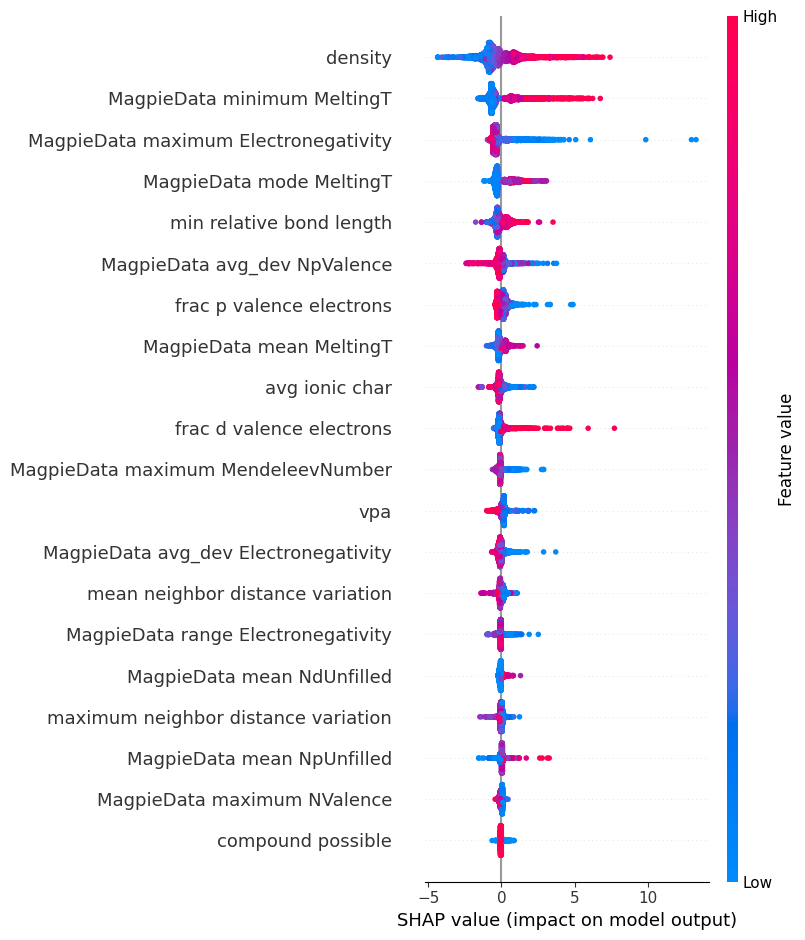

In [8]:
import shap
shap.initjs()

explainer1 = shap.Explainer(xgb_e)
shap_values1 = explainer1(X)
shap.summary_plot(shap_values1, X) 

[16:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


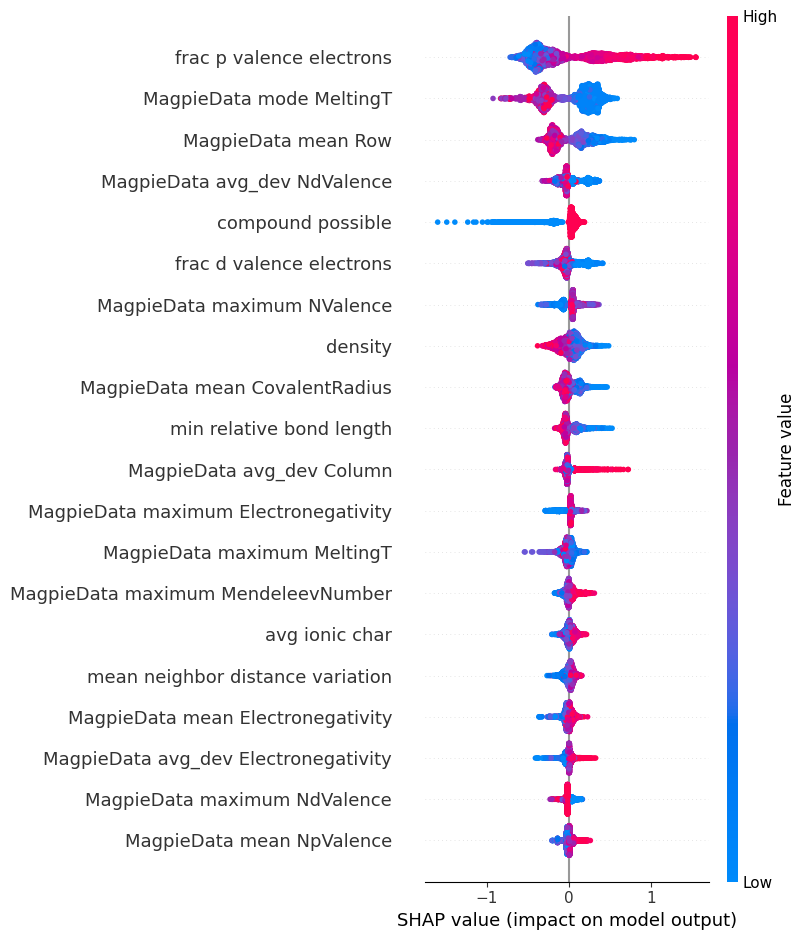

In [9]:

explainer1 = shap.Explainer(xgb_bg)
shap_values1 = explainer1(X)
shap.summary_plot(shap_values1, X)

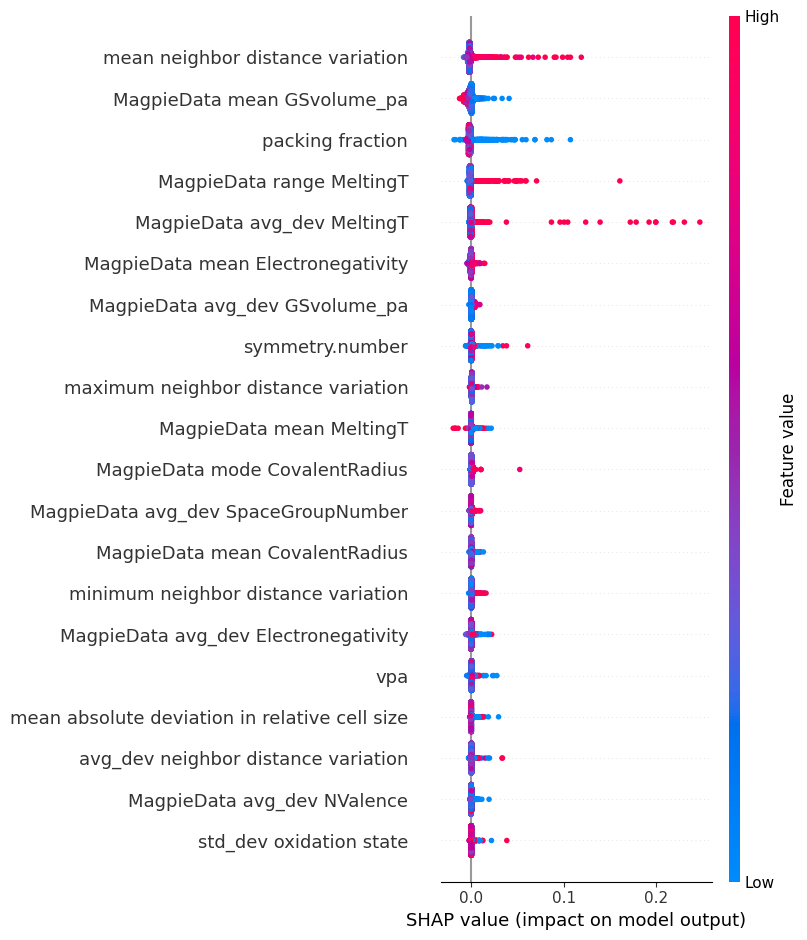

In [10]:

explainer1 = shap.Explainer(rf_eh)
shap_values1 = explainer1(X) 
shap.summary_plot(shap_values1, X)

In [47]:
import shelve

filename='shelve.out'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except:
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

ERROR shelving: Out
ERROR shelving: _15
ERROR shelving: _9
ERROR shelving: __builtin__
ERROR shelving: __builtins__
ERROR shelving: _oh
ERROR shelving: exit
ERROR shelving: get_ipython
ERROR shelving: np
ERROR shelving: open
ERROR shelving: pd
ERROR shelving: plt
ERROR shelving: quit
ERROR shelving: shap
ERROR shelving: shelve
ERROR shelving: varlist


In [2]:
import shelve
filename='shelve.out'
my_shelf = shelve.open(filename)
my_shelf

In [5]:
varlist = globals()
for key in my_shelf:
    if key not in varlist and key[0] != '_' and key[0] < 'e' and key[0]!='c':
        globals()[key] = my_shelf[key]

In [6]:
varlist = globals()
for key in my_shelf:
    if key not in varlist and key[0] != '_' and key[0] >= 'e' and key[0] < 'm':
        globals()[key] = my_shelf[key]

In [7]:
varlist = globals()
for key in my_shelf:
    if key not in varlist and (key[0] != '_' and key[0] >= 'n' and key[0]!='s'):
        globals()[key] = my_shelf[key]